[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2024/blob/main/docs/theme_H_update.ipynb)

# リプレイメモリによるモデルの忘却防止評価

0~8の手書き数字データで5エポック学習させたモデルに9の手書き数字データを1エポック学習させます。

In [ ]:
import torch
import copy
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
from collections import deque
import matplotlib.pyplot as plt

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データ変換
transform = transforms.Compose([transforms.ToTensor()])

# データセットのダウンロードと準備
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# クラス 0〜8 のデータのみを抽出
train_indices_0_8 = [i for i, (_, label) in enumerate(train_dataset) if label < 9]
train_dataset_0_8 = Subset(train_dataset, train_indices_0_8)

# クラス 9 のデータのみを抽出
train_indices_9 = [i for i, (_, label) in enumerate(train_dataset) if label == 9]
train_dataset_9 = Subset(train_dataset, train_indices_9)

# データローダの作成
train_loader_0_8 = DataLoader(train_dataset_0_8, batch_size=64, shuffle=True)
train_loader_9 = DataLoader(train_dataset_9, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# シンプルなニューラルネットワークモデル
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# モデル、損失関数、オプティマイザの定義
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# モデルの訓練関数
def train(model, loader, optimizer, criterion, epochs=1):
    model.train()
    for epoch in range(epochs):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    label_counts = [0] * 10  # MNISTのラベルは0〜9なので、10個のカウント用リストを準備

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 予測ラベルごとのカウントを更新
            for label in predicted:
                label_counts[label.item()] += 1

    # 精度を計算
    accuracy = correct / total

    return accuracy

# リプレイメモリのクラス（画像単位で保存）
class ReplayMemory:
    def __init__(self, max_size):
        self.memory = deque(maxlen=max_size)

    def add(self, image, label):
        self.memory.append((image, label))

    def sample(self, batch_size):
        # 個別の画像をランダムにサンプル
        return random.sample(self.memory, batch_size)

# リプレイメモリのインスタンスを作成
replay_memory = ReplayMemory(10000)

# リプレイメモリを使って訓練する関数（画像単位でサンプル）
def train_with_replay_memory(model, loader, optimizer, criterion, replay_memory=None, epochs=1, batch_size=64):
    model.train()
    for epoch in range(epochs):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # リプレイメモリから個別の画像をランダムにサンプル
            if replay_memory is not None and len(replay_memory.memory) > 0:
                replay_samples = replay_memory.sample(batch_size=batch_size)  # バッチサイズと同じ枚数
                replay_images, replay_labels = zip(*replay_samples)
                replay_images = torch.stack(replay_images).to(device)
                replay_labels = torch.tensor(replay_labels).to(device)

                # 新しいデータとリプレイメモリからのデータを結合
                combined_images = torch.cat([images, replay_images], dim=0)
                combined_labels = torch.cat([labels, replay_labels], dim=0)
            else:
                combined_images = images
                combined_labels = labels

            outputs = model(combined_images)
            loss = criterion(outputs, combined_labels)
            loss.backward()
            optimizer.step()

            # リプレイメモリに現在の画像を追加
            if replay_memory is not None:
                for img, lbl in zip(images, labels):
                    replay_memory.add(img, lbl)

# ステップ1: クラス 0～8 でモデルを学習
print("Training on classes 0-8...")
train(model, train_loader_0_8, optimizer, criterion, epochs=5)
accuracy_before = evaluate(model, test_loader, device)
print(f"Accuracy before learning class 9: {accuracy_before:.4f}")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.22MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 152kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.15MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training on classes 0-8...
Accuracy before learning class 9: 0.8794


普通に学習させるとモデルは0~8のデータを分類する方法を忘れてしまいます。

In [ ]:
model_no_replay = copy.deepcopy(model)

# ステップ2: リプレイメモリなしで、クラス 9 のデータで学習
print("Training on class 9 without replay memory...")
optimizer = optim.SGD(model_no_replay.parameters(), lr=0.01, momentum=0.9)
train(model_no_replay, train_loader_9, optimizer, criterion, epochs=3)
accuracy_after_no_replay = evaluate(model_no_replay, test_loader, device)
print(f"Accuracy after learning class 9 without replay memory: {accuracy_after_no_replay:.4f}")

Training on class 9 without replay memory...
Accuracy after learning class 9 without replay memory: 0.1508


リプレイメモリを使うことで忘却を防ぐことができます。  
リプレイメモリは0~8の手書き数字を保存しておくメモリで、9の手書き数字を学習する際にその一部を混ぜて学習が行われます。

Evaluating for batch size: 1
Evaluating for batch size: 4
Evaluating for batch size: 16
Evaluating for batch size: 64
Evaluating for batch size: 256


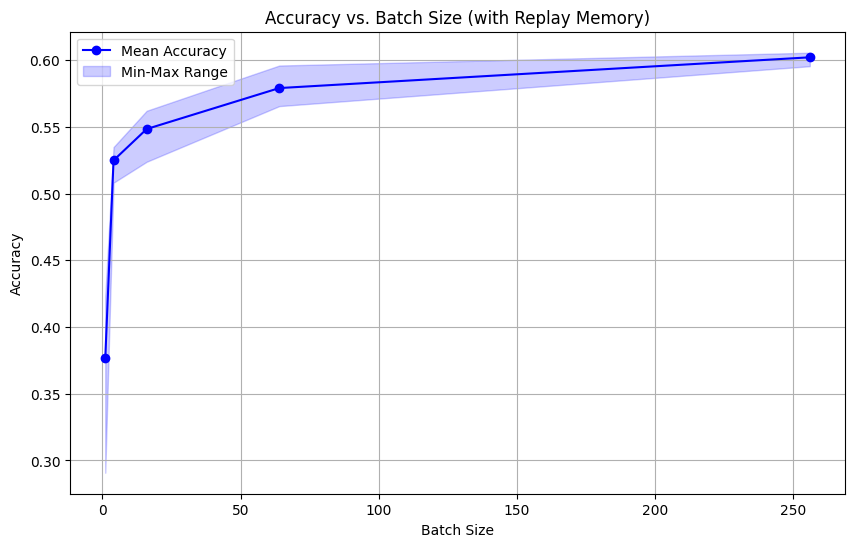

In [ ]:
model_replay = copy.deepcopy(model)

# バッチサイズを変更して複数回実行するための関数（リプレイメモリを関数内で作成）
def evaluate_with_varied_batch_sizes(model, train_loader_9, train_loader_0_8, criterion, batch_sizes, replay_memory_size, num_repeats, device):
    results = {}

    for batch_size in batch_sizes:
        print(f"Evaluating for batch size: {batch_size}")
        accuracies = []

        for _ in range(num_repeats):
            # 新しいモデルを作成して初期化
            temp_model = copy.deepcopy(model)
            temp_optimizer = optim.SGD(temp_model.parameters(), lr=0.01, momentum=0.9)

            # 新しいリプレイメモリを初期化
            replay_memory = ReplayMemory(max_size=replay_memory_size)

            # クラス 0-8 のデータをリプレイメモリに追加
            for images, labels in train_loader_0_8:
                for img, lbl in zip(images, labels):
                    replay_memory.add(img, lbl)

            # リプレイメモリからのトレーニング
            train_with_replay_memory(
                temp_model,
                train_loader_9,
                temp_optimizer,
                criterion,
                replay_memory=replay_memory,
                epochs=3,
                batch_size=batch_size
            )

            # 精度を測定
            accuracy = evaluate(temp_model, test_loader, device)
            accuracies.append(accuracy)

        # バッチサイズごとの結果を保存
        results[batch_size] = {
            'min': min(accuracies),
            'max': max(accuracies),
            'mean': sum(accuracies) / len(accuracies)
        }

    return results

# バッチサイズのリストと繰り返し回数を設定
batch_sizes = [1, 4, 16, 64, 256]
num_repeats = 5  # 同じバッチサイズで5回実行
replay_memory_size = 5000 # 1から45000まで

# 評価を実行
results = evaluate_with_varied_batch_sizes(
    model_replay,
    train_loader_9,
    train_loader_0_8,
    criterion,
    batch_sizes,
    replay_memory_size,
    num_repeats,
    device
)

# 結果をプロット
x = batch_sizes
y_min = [results[bs]['min'] for bs in batch_sizes]
y_max = [results[bs]['max'] for bs in batch_sizes]
y_mean = [results[bs]['mean'] for bs in batch_sizes]

plt.figure(figsize=(10, 6))
plt.plot(x, y_mean, label='Mean Accuracy', marker='o', color='blue')
plt.fill_between(x, y_min, y_max, color='blue', alpha=0.2, label='Min-Max Range')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Batch Size (with Replay Memory)')
plt.legend()
plt.grid()
plt.show()
